In [ ]:
# 런타임 재시작시
from google.colab import drive
drive.mount('/content/drive')

import os, torch

os.chdir("/content/drive/MyDrive/CProject/Tank-Model-Classification")
print("경로:", os.getcwd())

!git status

print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
경로: /content/drive/MyDrive/CProject/Tank-Model-Classification
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.gitignore
	runs/
	tank_nontank.ipynb
	yolo11n.pt

nothing added to commit but untracked files present (use "git add" to track)
CUDA: True
GPU: Tesla T4


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.gitignore
	runs/
	tank_nontank.ipynb
	yolo11n.pt

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!pwd

/content/drive/MyDrive/CProject/Tank-Model-Classification


# Tank-NonTank 모델
### 1. Vehicles 데이터: https://www.kaggle.com/datasets/nadinpethiyagoda/vehicle-dataset-for-yolo

- total images : 3000개  
classes
- car 1
- threewheel 2
- bus 3
- truck 4
- motorbike 5
- van 6

폴더 구조  
./tank_dataset/vehicle_dataset  
├── classes.txt  
├── train  
│   ├── images(2100, *.jpg)  
│   └── labels(2100, *.txt)  
└── valid  
 &nbsp;&nbsp;&nbsp;&nbsp;├── images(900, *.jpg)  
 &nbsp;&nbsp;&nbsp;&nbsp;└── labels(900, *.txt)  

### 2. Tank 데이터 : https://www.kaggle.com/datasets/saifkjarallah/tank-yolo-format-annotation-and-class-label5

- tanks image : 1785개  -> 2개 라벨 이상 삭제

폴더 구조  
./tank_dataset  
├── Tank  
│   └── Tank(1785, *.jpg)  
└── Tank_Labels  
 &nbsp;&nbsp;&nbsp;&nbsp;   └── Tank_Labels(1785, *txt)

---

### 데이터 준비 및 점검
- 데이터 라벨 정상적인지 확인
- Tank 라벨에 클래스가 다 5로 되어있음 -> 0으로 바꾸기
- 보류) vehicle_dataset -> 1로 바꾸기 (or 클래스 그대로 넣어줄지)
- 파일 이름 정리하기 tank_0001 - 1785 / car_001 - 500 ...


### tank 데이터


In [ ]:
# 탱크 데이터셋 클래스 번호 확인 -> 클래스가 (1, 5)로 구성
label_files = glob.glob("tank_dataset/Tank_Labels/Tank_Labels/*.txt")

class_ids = set()

for file in label_files:
    with open(file, "r") as f:
        for line in f:
            if line.strip() == "":
                continue
            class_id = line.split()[0]
            class_ids.add(class_id)

print(class_ids)


{'1', '5'}


In [ ]:
# 클래스 0으로 통일한다.
label_files = glob.glob("tank_dataset/Tank_Labels/Tank_Labels/*.txt")

for file in label_files:
    new_lines = []
    with open(file, "r") as f:
        for line in f:
            if line.strip() == "":
                continue
            parts = line.split()
            parts[0] = "0"        # 모든 클래스를 0 (tank) 로 강제 통일
            new_lines.append(" ".join(parts))

    with open(file, "w") as f:
        f.write("\n".join(new_lines))

print("모든 tank 라벨을 class 0 으로 통일 완료")


모든 tank 라벨을 class 0 으로 통일 완료


In [ ]:
 # Tank 데이터 파일이름 Tank_0000으로 통일
img_dir = "tank_dataset/Tank/Tank"
label_dir = "tank_dataset/Tank_Labels/Tank_Labels"

imgs = sorted(os.listdir(img_dir))
labels = sorted(os.listdir(label_dir))

assert len(imgs) == len(labels), "이미지와 라벨 개수가 다릅니다!"

for i, (img, lab) in enumerate(zip(imgs, labels), 1):
  new_name = f"Tank_{i:04d}"

  os.rename(os.path.join(img_dir, img),
            os.path.join(img_dir, new_name + ".jpg"))

  os.rename(os.path.join(label_dir, lab),
            os.path.join(label_dir, new_name + ".txt" ))

print("Tank 이미지 / 라벨 이름 정렬 리네이밍 완료")

Tank 이미지 / 라벨 이름 정렬 리네이밍 완료


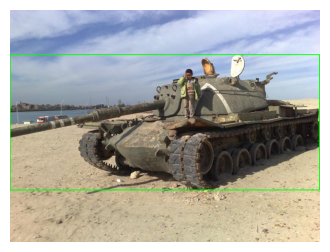

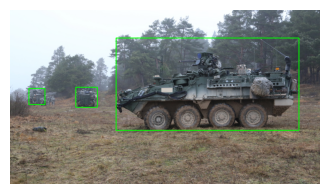

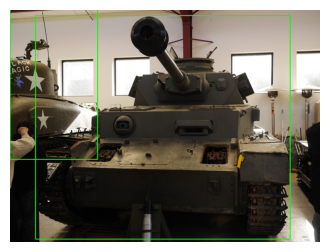

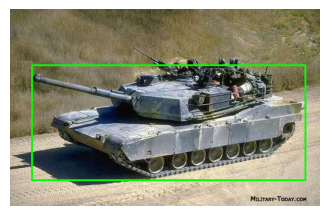

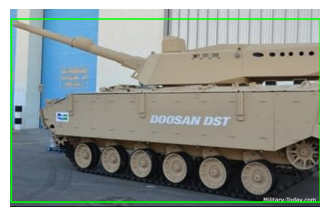

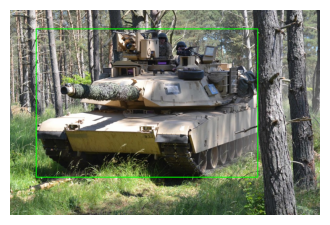

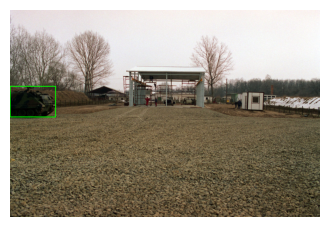

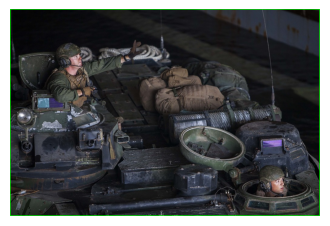

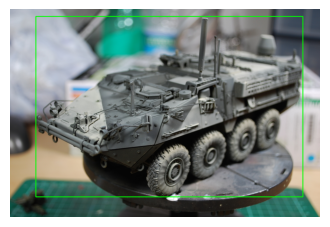

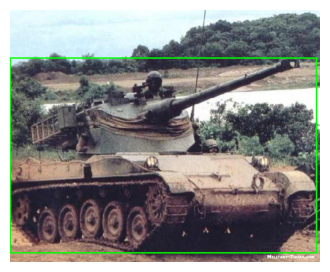

In [ ]:
# 10 개 샘플로 바운딩 박스 확인
import cv2
import random
import matplotlib.pyplot as plt

img_dir = "tank_dataset/Tank/Tank"
label_dir = "tank_dataset/Tank_Labels/Tank_Labels"

samples = random.sample(os.listdir(img_dir), 10)

for name in samples:
    img_path = os.path.join(img_dir, name)
    label_path = os.path.join(label_dir, name.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    with open(label_path) as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.split())
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)

            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:
# 비정상 라벨 확인 x,y는 0이상 1이하, w,h는 0초과 1이하여야함
bad_files = []

for file in os.listdir("tank_dataset/Tank_Labels/Tank_Labels"):
    with open(f"tank_dataset/Tank_Labels/Tank_Labels/{file}") as f:
        for line in f:
            if line.strip():
                cls,x,y,w,h = map(float,line.split())
                if not (0<=x<=1 and 0<=y<=1 and 0<w<=1 and 0<h<=1):
                    bad_files.append(file)
                    break

print(bad_files)


['Tank_1371.txt', 'Tank_1653.txt']


In [ ]:
# 비정상 라벨 삭제
for file in bad_files:
    os.remove(f"tank_dataset/Tank_Labels/Tank_Labels/{file}")
    os.remove(f"tank_dataset/Tank/Tank/{file.replace('.txt','.jpg')}")

print("깨진 데이터 삭제 완료")


깨진 데이터 삭제 완료


In [ ]:
# 검증
bad = 0
for file in os.listdir("tank_dataset/Tank_Labels/Tank_Labels"):
    with open(f"tank_dataset/Tank_Labels/Tank_Labels/{file}") as f:
        for line in f:
            if line.strip():
                _,x,y,w,h = map(float,line.split())
                if not (0<=x<=1 and 0<=y<=1 and 0<w<=1 and 0<h<=1):
                    bad += 1
print("비정상 라벨 수:", bad)


비정상 라벨 수: 0


### Vehicle 데이터

In [ ]:
# vehicle 데이터 셋에도 적용 - 파일명 정렬
base = "tank_dataset/vehicle_dataset"

for split in ["train", "valid"]:
    img_dir = f"{base}/{split}/images"
    label_dir = f"{base}/{split}/labels"

    imgs = sorted(os.listdir(img_dir))
    labels = sorted(os.listdir(label_dir))

    assert len(imgs) == len(labels), f"{split} 이미지/라벨 수 불일치"

    for i,(img,lab) in enumerate(zip(imgs,labels),1):
        new = f"vehicle_{split}_{i:05d}"
        os.rename(f"{img_dir}/{img}", f"{img_dir}/{new}.jpg")
        os.rename(f"{label_dir}/{lab}", f"{label_dir}/{new}.txt")

print("vehicle 파일명 정렬 완료")

vehicle 파일명 정렬 완료


In [ ]:
# 클래스 범위 점검 1-6
bad = []
for split in ["train","valid"]:
    for file in os.listdir(f"{base}/{split}/labels"):
        with open(f"{base}/{split}/labels/{file}") as f:
            for line in f:
                if line.strip():
                    cls,x,y,w,h = map(float,line.split())
                    if not (1 <= int(cls) <= 6):
                        bad.append(file)
                        break
print("클래스 오류 파일:", bad)


클래스 오류 파일: ['vehicle_train_00002.txt', 'vehicle_train_00003.txt', 'vehicle_train_00005.txt', 'vehicle_train_00006.txt', 'vehicle_train_00009.txt', 'vehicle_train_00010.txt', 'vehicle_train_00011.txt', 'vehicle_train_00013.txt', 'vehicle_train_00015.txt', 'vehicle_train_00019.txt', 'vehicle_train_00020.txt', 'vehicle_train_00021.txt', 'vehicle_train_00022.txt', 'vehicle_train_00025.txt', 'vehicle_train_00031.txt', 'vehicle_train_00034.txt', 'vehicle_train_00036.txt', 'vehicle_train_00039.txt', 'vehicle_train_00040.txt', 'vehicle_train_00041.txt', 'vehicle_train_00042.txt', 'vehicle_train_00043.txt', 'vehicle_train_00044.txt', 'vehicle_train_00045.txt', 'vehicle_train_00048.txt', 'vehicle_train_00049.txt', 'vehicle_train_00050.txt', 'vehicle_train_00051.txt', 'vehicle_train_00054.txt', 'vehicle_train_00055.txt', 'vehicle_train_00057.txt', 'vehicle_train_00061.txt', 'vehicle_train_00062.txt', 'vehicle_train_00063.txt', 'vehicle_train_00066.txt', 'vehicle_train_00069.txt', 'vehicle_train_0

In [ ]:
cls_set = set()

# tank
for file in os.listdir("tank_dataset/Tank_Labels/Tank_Labels"):
    with open(f"tank_dataset/Tank_Labels/Tank_Labels/{file}") as f:
        for line in f:
            if line.strip():
                cls_set.add(int(line.split()[0]))

# vehicle
base = "tank_dataset/vehicle_dataset"
for split in ["train","valid"]:
    for file in os.listdir(f"{base}/{split}/labels"):
        with open(f"{base}/{split}/labels/{file}") as f:
            for line in f:
                if line.strip():
                    cls_set.add(int(line.split()[0]))

print("클래스 set:", cls_set)

클래스 set: {0, 1, 2, 3, 4, 5}


- 비상 : vehicle 데이터셋 클래스1-6인줄 알았는데 0-5로 되어있었음
-> 1-6 클래스 쉬프트ㄱㄱ

In [ ]:
base = "tank_dataset/vehicle_dataset"

for split in ["train","valid"]:
    label_dir = f"{base}/{split}/labels"

    for file in os.listdir(label_dir):
        path = f"{label_dir}/{file}"
        new_lines = []

        with open(path) as f:
            for line in f:
                if line.strip():
                    parts = line.split()
                    parts[0] = str(int(parts[0]) + 1)   # 클래스 +1
                    new_lines.append(" ".join(parts))

        with open(path,"w") as f:
            f.write("\n".join(new_lines))

print("vehicle 클래스 전체 +1 시프트 완료")


vehicle 클래스 전체 +1 시프트 완료


In [ ]:
# 클래스 재점검 1-6
bad = []
for split in ["train","valid"]:
    for file in os.listdir(f"{base}/{split}/labels"):
        with open(f"{base}/{split}/labels/{file}") as f:
            for line in f:
                if line.strip():
                    cls,x,y,w,h = map(float,line.split())
                    if not (1 <= int(cls) <= 6):
                        bad.append(file)
                        break
print("클래스 오류 파일:", bad)

클래스 오류 파일: []


### 이제 클래스 정상화
0:tank 1: car 2:threewheel 3:bus 4:truck 5:motorbike 6:van

In [ ]:
# 좌표검증
bad = []
for split in ["train","valid"]:
    for file in os.listdir(f"{base}/{split}/labels"):
        with open(f"{base}/{split}/labels/{file}") as f:
            for line in f:
                if line.strip():
                    _,x,y,w,h = map(float,line.split())
                    if not (0<=x<=1 and 0<=y<=1 and 0<w<=1 and 0<h<=1):
                        bad.append(file)
                        break
print("좌표 깨진 파일:", bad)


좌표 깨진 파일: []


In [ ]:
# 샘플 10개 확인

img_dir = f"{base}/train/images"
lab_dir = f"{base}/train/labels"

samples = random.sample(os.listdir(img_dir), 8)

for s in samples:
    img = cv2.imread(f"{img_dir}/{s}")
    h,w,_ = img.shape
    with open(f"{lab_dir}/{s.replace('.jpg','.txt')}") as f:
        for l in f:
            c,x,y,bw,bh = map(float,l.split())
            x1=int((x-bw/2)*w); y1=int((y-bh/2)*h)
            x2=int((x+bw/2)*w); y2=int((y+bh/2)*h)
            cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(img,str(int(c)),(x1,y1-3),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.show()


Output hidden; open in https://colab.research.google.com to view.

### 점검 완료

## 데이터셋 분리 (YOLOv11)
- yolo_dataset 파일만들어서 train, val 파일 7:3로 분리후 복사

## 최종 데이터 셋
tank_dataset/yolo_dataset(4783)  
├── train  
│   ├── images(3348)  
│   └── labels  
└── val  
    ├── images(1435)  
    └── labels  

In [ ]:
import os, random, shutil

img_dir = "tank_dataset/Tank/Tank"
lab_dir = "tank_dataset/Tank_Labels/Tank_Labels"
out = "tank_dataset/yolo_dataset"

for s in ["train","val"]:
    os.makedirs(f"{out}/{s}/images", exist_ok=True)
    os.makedirs(f"{out}/{s}/labels", exist_ok=True)

files = sorted(os.listdir(img_dir))
random.shuffle(files)

split = int(len(files)*0.7)
train_files = files[:split]
val_files   = files[split:]

def copy(files, split):
    for f in files:
        shutil.copy(f"{img_dir}/{f}", f"{out}/{split}/images/{f}")
        shutil.copy(f"{lab_dir}/{f.replace('.jpg','.txt')}", f"{out}/{split}/labels/{f.replace('.jpg','.txt')}")

copy(train_files,"train")
copy(val_files,"val")

print("tank 7:3 split 완료")


tank 7:3 split 완료


In [ ]:
import shutil, os

veh = "tank_dataset/vehicle_dataset"

for split in ["train","valid"]:
    tgt = "val" if split=="valid" else "train"
    for f in os.listdir(f"{veh}/{split}/images"):
        shutil.copy(f"{veh}/{split}/images/{f}", f"{out}/{tgt}/images/{f}")
        shutil.copy(f"{veh}/{split}/labels/{f.replace('.jpg','.txt')}", f"{out}/{tgt}/labels/{f.replace('.jpg','.txt')}")

print("vehicle 데이터 병합 완료")



vehicle 데이터 병합 완료


In [ ]:
# yaml 파일 생성
yaml_text = """
path: tank_dataset/yolo_dataset

train: train/images
val: val/images

names:
  0: tank
  1: car
  2: threewheel
  3: bus
  4: truck
  5: motorbike
  6: van
"""

with open("tank_dataset/data.yaml","w") as f:
    f.write(yaml_text.strip())

print("data.yaml 생성 완료")


data.yaml 생성 완료


In [ ]:
# 최종 구조 확인
!tree tank_dataset/yolo_dataset -L 2


tank_dataset/yolo_dataset
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels

6 directories, 0 files


----
## YOLOv11 학습

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")   # 초반은 n부터
model.train(
    data="tank_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=tank_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bfe8155e780>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
model.val(data="tank_dataset/data.yaml")

Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 39.8±30.6 MB/s, size: 148.1 KB)
val: Scanning /content/drive/MyDrive/CProject/Tank-Model-Classification/tank_dataset/yolo_dataset/val/labels.cache... 1435 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1435/1435 354.0Mit/s 0.0s
val: /content/drive/MyDrive/CProject/Tank-Model-Classification/tank_dataset/yolo_dataset/val/images/vehicle_valid_00551.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 90/90 3.2it/s 28.2s
                   all       1435       1951      0.963      0.923      0.972      0.885
                  tank        535        801      0.915      0.794      0.902      0.666
                   car        182        201      0.921       0.91      0.971      0.941
 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bfe761ac890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(64,

In [ ]:
model.model.info()


YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


(101, 2583517, 0, 6.3194624)